In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from os import listdir
from os.path import isfile, join
import cv2
import imageio
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
imagesDir = 'katkam-scaled'
weatherDataDir = 'yvr-weather'
   #https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
onlyfiles = [ f for f in listdir(imagesDir) if isfile(join(imagesDir,f)) ]

In [3]:
images = np.empty(len(onlyfiles), dtype=object)

for n in range(0, len(onlyfiles)):
      images[n] = cv2.imread( join(imagesDir,onlyfiles[n]) )

In [4]:
weatherDataFiles = [ f for f in listdir(weatherDataDir) if isfile(join(weatherDataDir,f)) ]

In [5]:
weatherData = pd.read_csv(join(weatherDataDir, weatherDataFiles[0]), usecols=[1, 2, 3, 4, 6, 24], skiprows=np.linspace(0, 15))

In [6]:
for n in range(1, len(weatherDataFiles)):
    weatherData = weatherData.append(pd.read_csv(join(weatherDataDir, weatherDataFiles[n]), usecols=[1, 2, 3, 4, 6, 24], skiprows=np.linspace(0, 15)))
    

In [7]:
weatherDataCleaned = weatherData.dropna().reset_index(drop=True)

In [8]:
weatherDataCleaned['ID'] = weatherDataCleaned['Year']*1e6 + weatherDataCleaned['Month']*1e4 + weatherDataCleaned['Day']*1e2 + weatherDataCleaned['Time'].str.slice(0, 2).astype(float)
weatherDataCleaned['ID'] = weatherDataCleaned['ID'].astype(int)

In [9]:
actualImages = np.empty([weatherDataCleaned.shape[0], 192, 256, 3], dtype=np.uint8)

In [10]:
numImages = 0
imageIdx = np.full(weatherDataCleaned.shape[0], -1)
for n in range(0, weatherDataCleaned.shape[0]):
    filename = "katkam-" + str(weatherDataCleaned['ID'][n]) + "0000" + ".jpg"
    if (filename in onlyfiles):
        actualImages[numImages, :, :, :] = imageio.imread(join(imagesDir, filename))
        imageIdx[n] = numImages
        numImages = numImages+1

In [11]:
weatherDataCleaned['hasImage'] = imageIdx

In [12]:
weatherDataCleaned = weatherDataCleaned[weatherDataCleaned['hasImage'] >= 0]
actualImages = actualImages[ 0:numImages, :, :, :]

In [13]:
greyImages = np.uint8((actualImages[:, :, :, 0].astype(np.float) + actualImages[:, :, :, 1].astype(np.float) + actualImages[:, :, :, 2].astype(np.float))/3)

In [14]:
#unravelled = greyImages.reshape(np.shape(greyImages)[0], np.shape(greyImages)[1]*np.shape(greyImages)[2])
#unravelled[100, 0:2560:256]
#images_train, images_test, names_train, names_test = train_test_split(unravelled, weatherDataCleaned['Weather'].values)
#myModel = make_pipeline(
    #PCA(200),
    #SVC(C=1))
#myModel.fit(images_train, names_train)
#myModel.score(images_test, names_test)

In [15]:
skies = actualImages[:, 0:100, :, :]

In [16]:
blueness = (skies[:, :, :, 2].sum(axis=(1, 2)))/(skies[:, :, :, :].sum(axis=(1, 2, 3)))

In [17]:
lightlevel = (skies[:, :, :, :].sum(axis=(1, 2, 3)))

In [18]:
weatherDataCleaned['Blueness'] = blueness

In [29]:
weatherDataCleaned['Brightness'] = lightlevel

In [30]:
weatherDataReady = weatherDataCleaned[weatherDataCleaned['Brightness'] > 6000000]

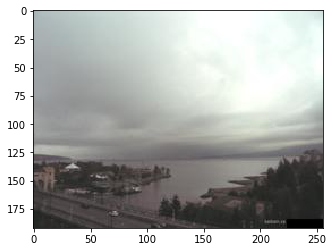

In [119]:
# Find blueness of sky
# Cutoff sky part
plt.imshow(actualImages[2831, :, :, :])
plt.show()

In [32]:
lightlevel

array([10898682, 12242949, 14474643, ..., 15233917, 15117650, 11938390], dtype=uint32)

In [33]:
parameters = weatherDataReady[['Blueness', 'Brightness']].values

In [34]:
np.shape(parameters)

(2707, 2)

In [109]:
images_train, images_test, names_train, names_test = train_test_split(weatherDataReady[['Blueness', 'Brightness']].values, weatherDataReady[['Weather']].values)
myModel = make_pipeline(
    StandardScaler(),
    SVC(C=1))

In [110]:
np.shape(names_train)

(2030, 1)

In [111]:
myModel.fit(images_train, names_train)

C:\Users\adria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [112]:
myModel.score(images_test, names_test)

0.3988183161004431

In [115]:
weatherDataReady['Weather'].unique()

array(['Mainly Clear', 'Mostly Cloudy', 'Cloudy', 'Rain Showers',
       'Moderate Rain Showers', 'Clear', 'Rain', 'Rain,Fog', 'Drizzle',
       'Rain Showers,Fog', 'Thunderstorms', 'Fog', 'Drizzle,Fog',
       'Moderate Rain Showers,Fog', 'Rain,Drizzle', 'Moderate Rain',
       'Moderate Rain,Drizzle', 'Moderate Rain,Fog', 'Rain,Drizzle,Fog',
       'Heavy Rain,Fog', 'Snow', 'Snow,Fog', 'Rain,Snow', 'Freezing Fog',
       'Rain,Snow,Fog', 'Moderate Snow', 'Snow Showers',
       'Rain Showers,Snow Showers,Fog', 'Rain Showers,Snow Pellets',
       'Rain Showers,Snow Showers',
       'Heavy Rain Showers,Moderate Snow Pellets,Fog',
       'Heavy Rain,Moderate Hail,Fog'], dtype=object)

In [117]:
weatherDataReady[weatherDataReady['Weather'] == 'Heavy Rain Showers,Moderate Snow Pellets,Fog']

,Year,Month,Day,Time,Temp (°C),Weather,ID,hasImage,Blueness,LightLevel,Brightness
5440,2017,10,12,08:00,6.2,"Heavy Rain Showers,Moderate Snow Pellets,Fog",2017101208,2831,0.332799,16263246,16263246
